<a href="https://colab.research.google.com/github/danilovabg/ML-DL/blob/master/Yoga_poses_detection/training_file_for_yoga_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastai

In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [19]:
DEVICE = 'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/yoga_poses_dataset.zip

In [5]:
from pathlib import Path
TRAIN_DIR = Path('/content/yoga_poses_dataset')
train_val_files = list(TRAIN_DIR.rglob('*.png'))
print(len(train_val_files)) #=> 5897

5897


In [6]:
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте


In [8]:
class YogaPosesDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_


    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform(x)
            return x
        else:
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
      w, h = image.size
      if h>w:
        image = transforms.functional.pad(image, padding = [round(abs(h-w)/2), 0])
      else:
        image = transforms.functional.pad(image, padding = [0, round(abs(h-w)/2)])
      image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
      return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state = 42)
val_dataset = YogaPosesDataset(val_files, mode='val')

Давайте посмотрим на картинки внутри датасета.

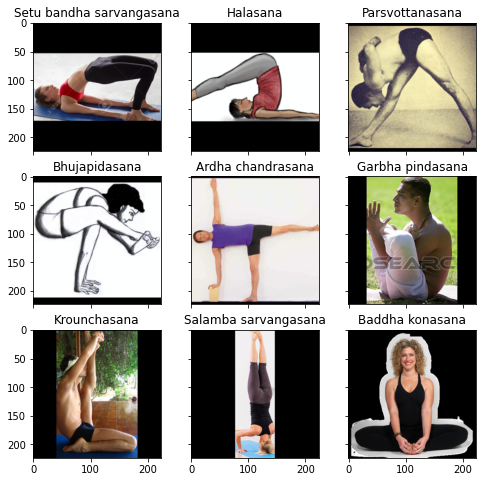

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data, \
          title=img_label,plt_ax=fig_x)

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        #inputs = inputs.to(DEVICE)
        #labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        #inputs = inputs.to(DEVICE)
        #labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [14]:
full_set_enc = LabelEncoder()
full_set_labels = [path.parent.name for path in train_val_files]
full_set_enc.fit(full_set_labels);

In [25]:
def train(train_loader, val_loader, model,  scheduler, optim, criterion, epochs, batch_size):  

    history = []
    best_acc = 0.0
    best_model_wghts = model.state_dict()
    # pbar = trange(epochs, desc="Epoch:")
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"


    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())
        # criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optim, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if val_acc > best_acc:
              best_acc = val_acc
              best_model_wghts = model.state_dict()

    torch.cuda.empty_cache()
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            model.eval()
            outputs = model(inputs)
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))

we will classify :107


Запустим обучение сети.

In [27]:
from torchvision import models
train_dataset = YogaPosesDataset(train_files, mode='train')
val_dataset = YogaPosesDataset(val_files, mode='val')

BATCH_SIZE = 32
NUM_CLASSES = len(np.unique(full_set_labels))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Вычисляем веса для train_dataset
_, counts = np.unique(np.array(full_set_enc.transform(train_dataset.labels)), return_counts=True)
weights = 1./counts
samples_weight = np.array([weights[t] for t in full_set_enc.transform(train_dataset.labels)])

# Создаем сэмплер
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# Создаём даталоадер
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)


# Возьмем самый простой вариант, не будем применять аугментации и взвешенное сэмплирование.
# Просто EfficientNet_b0 с заменой классификатора одним линейным слоем.
effnet_b0 = models.efficientnet_b0(pretrained=True)
effnet_b0.classifier = nn.Linear(1280, 107, bias=True)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(effnet_b0.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optim, gamma = 0.7)
# effnet_b0.to(DEVICE)
# Зададим лосс функцию и оптимизатор

history = train(train_loader, val_loader, effnet_b0, scheduler, optim, criterion, epochs=7, batch_size = 32)

     


epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 2.55300248688241


epoch:  14%|█▍        | 1/7 [04:39<27:57, 279.56s/it]


Epoch 001 train_loss: 2.5530     val_loss 1.7089 train_acc 0.3930 val_acc 0.5200
loss 1.205143518654915


epoch:  29%|██▊       | 2/7 [08:17<20:17, 243.51s/it]


Epoch 002 train_loss: 1.2051     val_loss 1.4550 train_acc 0.6551 val_acc 0.6088
loss 0.588840008900749


epoch:  43%|████▎     | 3/7 [11:57<15:30, 232.55s/it]


Epoch 003 train_loss: 0.5888     val_loss 1.2558 train_acc 0.8211 val_acc 0.6820
loss 0.36121560518483686


epoch:  57%|█████▋    | 4/7 [15:40<11:26, 228.77s/it]


Epoch 004 train_loss: 0.3612     val_loss 1.1099 train_acc 0.8856 val_acc 0.7092
loss 0.17752843403751523


epoch:  71%|███████▏  | 5/7 [19:22<07:33, 226.53s/it]


Epoch 005 train_loss: 0.1775     val_loss 1.1529 train_acc 0.9423 val_acc 0.7322
loss 0.11764304460608031


epoch:  86%|████████▌ | 6/7 [23:03<03:44, 224.45s/it]


Epoch 006 train_loss: 0.1176     val_loss 1.1317 train_acc 0.9627 val_acc 0.7363
loss 0.0755034640738054


epoch: 100%|██████████| 7/7 [26:46<00:00, 229.53s/it]


Epoch 007 train_loss: 0.0755     val_loss 1.1828 train_acc 0.9729 val_acc 0.7363


Построим кривые обучения

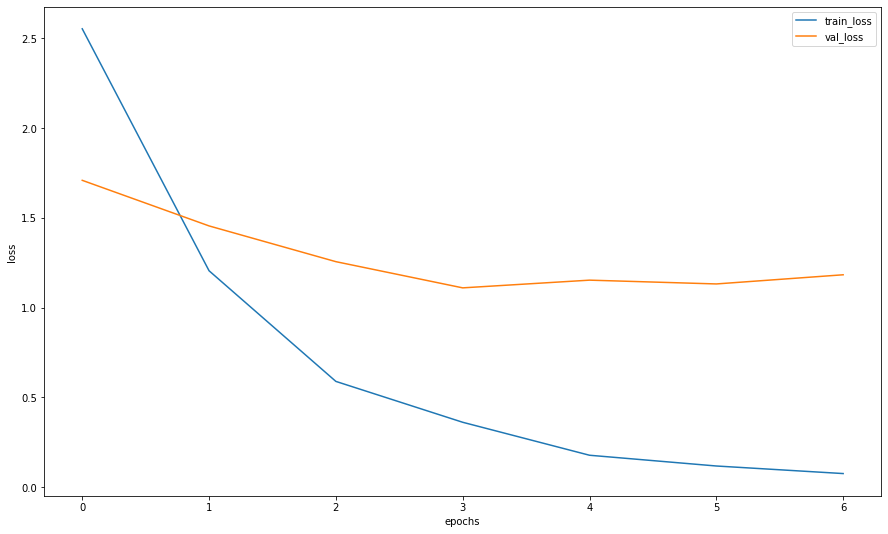

In [28]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

к сожалению модель не идеальна, это связано с тем что есть несколько видов визуально похожих поз которые модель путает

в дальнейшем для улучшения модели необходимо будет собрать больше разнообразных фото поз йоги


сохраняем тренированную модуль

In [ ]:
pickle.dump(effnet_b0, open('/content/gdrive/MyDrive/yoga_poses_classificator_model.pkl', 'wb'))